In [2]:
# Libraries
## Mathematics
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import re

## Visualization
import matplotlib.pyplot as plt

In [2]:
# Load functions .py files
from Practical_case_functions import EM_Algorithm, KDE, sigma_log_likelihood_vectorized, process_classificator
from Perspective_comparison_functions import simulate_brownian_bridge
from Visualisation import OSB_visualisation, OSB_visualisation_practical_case
from Checking_simulated_boundary_functions_3 import optimal_stopping_montecarlo_3

# Data preparation

## Options dataframe

In [3]:
# Auxiliar functions
def rename_column_call(col):
    match = re.search(r"^CALL IBM\$ JUN18 (\d{2,3})\b", col)
    return match.group(1) if match else col

def rename_column_put(col):
    match = re.search(r"^PUT IBM\$ JUN18 (\d{2,3})\b", col)
    return match.group(1) if match else col

In [4]:
df_options_call = pd.read_csv(r'C:\Users\User\Documents\Data\IBM_CallOptions_DailyOI_JAN2010-NOV2018.csv', sep=',', header=0, low_memory=False)
call_dates = df_options_call['Date']
df_options_put = pd.read_csv(r'C:\Users\User\Documents\Data\IBM_PutOptions_DailyOI_JAN2010-NOV2018.csv', sep=',', header=0, low_memory=False)
put_dates = df_options_put['Name']

# Filter columns of interest
df_options_call = df_options_call[[col for col in df_options_call.columns if col.startswith("CALL IBM$ JUN18")]]
df_options_call.columns = [rename_column_call(col) for col in df_options_call.columns]

df_options_put = df_options_put[[col for col in df_options_put.columns if col.startswith("PUT IBM$ JUN18")]]
df_options_put.columns = [rename_column_put(col) for col in df_options_put.columns]

# Add date
df_options_call.insert(0, 'Date', call_dates)
df_options_put.insert(0, 'Date', put_dates)

# Filter no NaN rows
df_options_call = df_options_call[df_options_call.iloc[:, 1:].notna().any(axis=1)]
df_options_put = df_options_put[df_options_put.iloc[:, 1:].notna().any(axis=1)]

# Impute 0 for the values NaN
df_options_call.fillna(0, inplace=True)
df_options_put.fillna(0, inplace=True)

# Create final dataset
## Merge using outer join with 'Date' as key
df_combined = pd.merge(df_options_put, df_options_call, on='Date', how='outer', suffixes=('_put', '_call'))

## Initialise the new dataframe with the column 'Date'
df_options_final = pd.DataFrame()
df_options_final['Date'] = df_combined['Date']

## Consider all common columns
common_strikes = set(df_options_put.columns[1:]).intersection(set(df_options_call.columns[1:]))

## Add common columns (all)
for strike in common_strikes:
    df_options_final[strike] = df_combined[f'{strike}_put'].fillna(0) + df_combined[f'{strike}_call'].fillna(0)

## Order columns: 'Date' first and then the ordered strikes
df_options_final = df_options_final[['Date'] + sorted(common_strikes, key=lambda x: int(x))]


## Create a categorical type with call_dates order to preserve order after sorting
df_options_final['Date'] = pd.Categorical(df_options_final['Date'], categories=call_dates, ordered=True)

## Sort by the categorical 'Date' column
df_options_final = df_options_final.sort_values('Date').reset_index(drop=True)

## Visualise final dataframe
df_options_final

,Date,75,80,85,90,95,100,105,110,115,...,190,195,200,205,210,215,220,230,240,250
0,8/2/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9/2/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10/2/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13/02/2017,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14/02/2017,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,8/6/2018,1188.0,1312.0,1820.0,93.0,200.0,723.0,719.0,408.0,11875.0,...,3712.0,278.0,3759.0,0.0,649.0,0.0,183.0,92.0,206.0,1923.0
348,11/6/2018,1188.0,1312.0,1820.0,93.0,200.0,721.0,719.0,408.0,11875.0,...,3712.0,278.0,3759.0,0.0,649.0,0.0,183.0,92.0,206.0,1923.0
349,12/6/2018,1188.0,1312.0,1820.0,93.0,200.0,721.0,719.0,408.0,11870.0,...,3712.0,278.0,3759.0,0.0,649.0,0.0,183.0,92.0,206.0,1923.0
350,13/06/2018,1188.0,1312.0,1820.0,93.0,200.0,721.0,719.0,408.0,11870.0,...,3712.0,278.0,3759.0,0.0,649.0,0.0,183.0,92.0,206.0,1923.0


In [5]:
# Define Z_1
date = "15/05/2018"
options_date = df_options_final[df_options_final['Date'] == date]
tilde_Z_1 = np.array([])
for col in options_date.columns[1:]:
    volume = options_date[col].values[0]
    if volume > 0:
        new_array = np.full(int(volume), int(col))
        tilde_Z_1 = np.concatenate((tilde_Z_1, new_array))
tilde_Z_1

array([ 75.,  75.,  75., ..., 250., 250., 250.])

## Stock dataframe

In [6]:
# Read data
df_stocks = pd.read_csv(r'C:\Users\User\Documents\Data\IBM_5minPrice_ 25JUL2008 - 13DEC2018.csv', sep=',', header=0, low_memory=False)
df_stocks_result = df_stocks.copy()

# Extract data of interest
df_stocks["Date"] = df_stocks["Time.Interval"].str[:9]
first_date = "08FEB2017"
first_date_index = df_stocks.index[df_stocks["Date"] == first_date][0]
observation_date = "15MAY2018"
observation_date_index = df_stocks.index[df_stocks["Date"] == observation_date][0]
last_date = "14JUN2018"
last_date_index = df_stocks.index[df_stocks["Date"] == last_date][0]+78 # Add 78 that are all the intervals considered in a day
df_stocks_subset = df_stocks.loc[first_date_index:last_date_index]
days_considered = df_stocks_subset.isna().any(axis=1).sum()
df_stocks_filtered = df_stocks_subset.dropna(axis=0)

df_stocks_filtered1 = df_stocks_filtered[["Close", "Open", "High", "Low"]]
df_stocks_filtered2 = df_stocks_filtered1.copy()
df_stocks_filtered2["Middle"] = (df_stocks_filtered1["High"] + df_stocks_filtered1["Low"])/2

# Save final dataset
df_stocks_final = df_stocks_filtered2
df_stocks_training = df_stocks_final.loc[:observation_date_index]
df_stocks_testing = df_stocks_final.loc[observation_date_index:]
print(df_stocks_training.head())
print(df_stocks_testing.head())

         Close     Open     High      Low    Middle
168924  178.34  178.270  178.355  178.260  178.3075
168925  178.28  178.330  178.370  178.260  178.3150
168926  178.27  178.270  178.310  178.270  178.2900
168927  178.33  178.279  178.335  178.240  178.2875
168928  178.29  178.340  178.390  178.228  178.3090
          Close     Open    High     Low   Middle
194014  143.615  143.500  143.99  143.39  143.690
194015  143.830  143.640  143.92  143.53  143.725
194016  143.490  143.820  143.88  143.42  143.650
194017  143.305  143.481  143.55  143.24  143.395
194018  143.310  143.250  143.42  143.18  143.300


In [26]:
T = len(df_stocks_final["Middle"])

# Density estimation

## KDE

In [8]:
# KDE 
weights_KDE, parameters_KDE = KDE(Z_1 = tilde_Z_1)

## EM Algorithm

In [9]:
# EM Algorithm
weights_EM, parameters_EM = EM_Algorithm(Z_1 = tilde_Z_1, n_components = "BIC", n_components_trials = len(weights_KDE)-1)

The lowest BIC was achieved with 2 components.


# Volatility estimation

## Maximise log-likelihood function verification

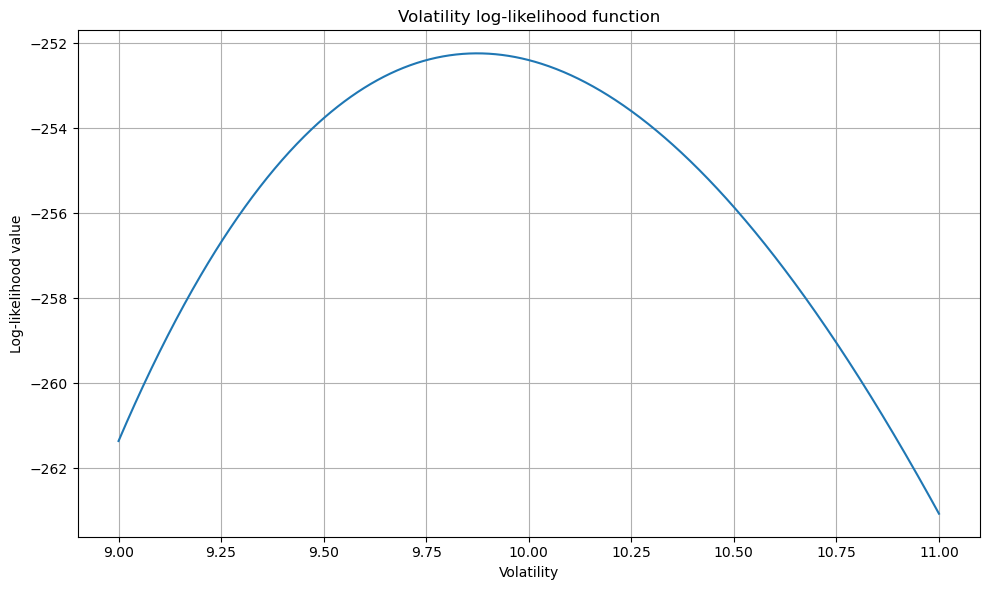

In [10]:
# Initialize parameters
n = df_stocks_final.shape[0]*5
weights = np.array([1/4, 1/2, 1/4])
parameters = np.array([[-5/9, 0, 1],[2/3, 1/3, 1/2]])
volatility = 10

# Initialize variables
m_tilde = parameters[0]
gamma_tilde = parameters[1]

# Sample distributions
np.random.seed(123)
selection = np.random.choice(list(range(0,parameters.shape[1])), size = 1, p = weights)
z1 = np.random.normal(loc=m_tilde[selection], scale=gamma_tilde[selection]) # Generated M values of the distribution Z_1
process = simulate_brownian_bridge(t = 0, z_t = 0, T = 1, z_T = z1[0], n_steps = 1000, volatility = volatility) # Simulated the brownian brigdge to t+u
tilde_z_t = process[1]
t = process[0]

# Maximise loglikelihood function
loglikelihood = [sigma_log_likelihood_vectorized(i, tilde_z_t, t, m_tilde, gamma_tilde, weights) for i in np.linspace(9, 11, 1000)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(9, 11, 1000), loglikelihood)
plt.xlabel('Volatility')
plt.ylabel('Log-likelihood value')
plt.title("Volatility's log-likelihood function")
plt.grid(True)
plt.tight_layout()
#plt.savefig("loglikelihood_function", dpi=300)
plt.show()

C:\Users\User\Documents\GitHub\Opt-stopp-BB-random-pinning-point\Practical_case_functions.py:167: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(inner_sums))


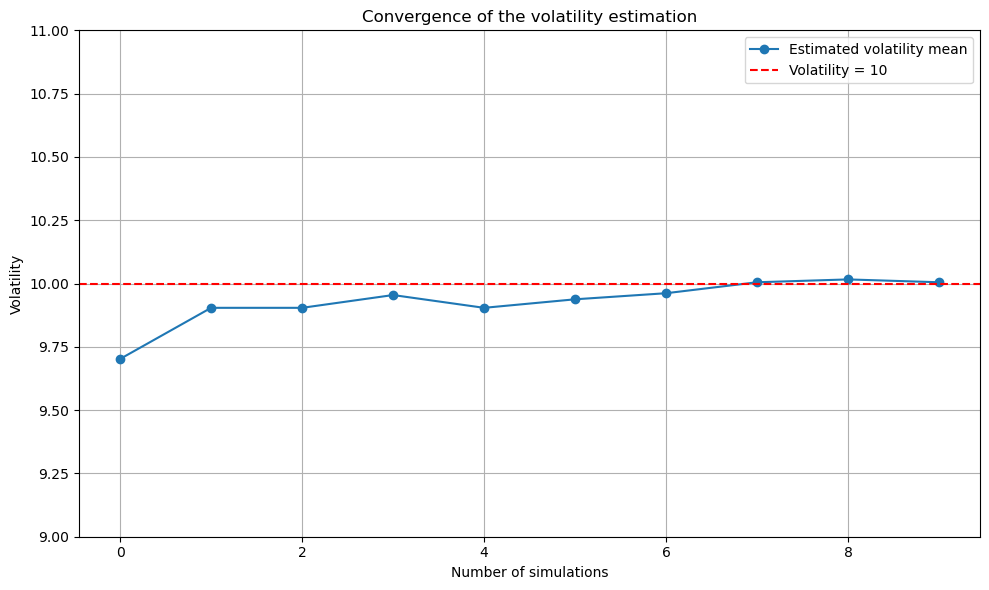

In [11]:
# Initialize parameters
n = df_stocks_final.shape[0]*5
weights = np.array([1/4, 1/2, 1/4])
parameters = np.array([[-5/9, 0, 1],[2/3, 1/3, 1/2]])
volatility = 10

# Initialize variables
m_tilde = parameters[0]
gamma_tilde = parameters[1]

# Simulate process and estimate volatility
estimated_volatility = []
for _ in range(100):
    # Sample distributions
    selection = np.random.choice(list(range(0,parameters.shape[1])), size = 1, p = weights)
    z1 = np.random.normal(loc=m_tilde[selection], scale=gamma_tilde[selection]) # Generated M values of the distribution Z_1
    process = simulate_brownian_bridge(t = 0, z_t = 0, T = 1, z_T = z1[0], n_steps = 1000, volatility = volatility) # Simulated the brownian brigdge to t+u
    tilde_z_t = process[1]
    t = process[0]
    
    # Maximise loglikelihood function
    loglikelihood = [sigma_log_likelihood_vectorized(i, tilde_z_t, t, m_tilde, gamma_tilde, weights) for i in np.linspace(0.01, 20, 100)]
    estimated_volatility.append(np.linspace(0.01, 20, 100)[loglikelihood.index(max(loglikelihood))])

# Accumulated mean
mean_estimates = [np.mean(estimated_volatility[:i+1]) for i in range(len(estimated_volatility))]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_estimates)), mean_estimates, marker='o', label='Estimated volatilities mean')
plt.axhline(y=volatility, color='r', linestyle='--', label=f'Volatility = {volatility}')
plt.xlabel('Number of simulations')
plt.ylabel('Volatility')
plt.title('Convergence of the volatility's maximum likelihood estimator expectance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(9, 11)
plt.savefig("Volatility_est", dpi=300)
plt.show()


In [12]:
tilde_z_t_training = df_stocks_training['Middle']
tilde_z_t_testing = df_stocks_testing['Middle']
Z_0 = tilde_z_t_training.iloc[0]
t = np.linspace(0, 1, T)
t_training = t[:len(tilde_z_t_training)]
t_testing = t[len(tilde_z_t_training):]

## EM Algorithm

In [28]:
# Initialize variables
tilde_m = parameters_EM[0]
tilde_gamma = parameters_EM[1]
pi = weights_EM

# Maximize log-likelihood function
volatility_tries = np.linspace(40, 60, 1000)
loglikelihood = [sigma_log_likelihood_vectorized(i, tilde_z_t_training, t_training, tilde_m, tilde_gamma, pi) for i in volatility_tries]
volatility_EM = volatility_tries[loglikelihood.index(max(loglikelihood))]

np.save("volatility_EM.npy", volatility_EM)
print(volatility_EM)

48.888888888888886


## KDE

In [14]:
# Initialize variables
tilde_m = parameters_KDE[0]
tilde_gamma = parameters_KDE[1]
pi = weights_KDE

# Maximize log-likelihood function
volatility_tries = np.linspace(40, 60, 1000)
loglikelihood = [sigma_log_likelihood_vectorized(i, tilde_z_t_training, t_training, tilde_m, tilde_gamma, pi) for i in volatility_tries]
volatility_KDE = volatility_tries[loglikelihood.index(max(loglikelihood))]

np.save("volatility_KDE.npy", volatility_KDE)
print(volatility_KDE)

48.888888888888886


## Difference

In [ ]:
volatility_EM = np.load("volatility_EM.npy")
volatility_KDE = np.load("volatility_KDE.npy")

In [15]:
difference = abs(volatility_KDE-volatility_EM)
print(f"The difference between volatilities is: {difference}")

The difference between volatilities is: 1.212121212121211


## EM Algorithm

In [16]:
Z_1_EM = (tilde_Z_1 -  Z_0)/volatility_EM

m_EM = (parameters_EM[0] -  Z_0)/volatility_EM
gamma_EM = parameters_EM[1]/volatility_EM
parameters_EM = np.stack((m_EM, gamma_EM), axis=0)

## KDE

In [18]:
Z_1_KDE = (tilde_Z_1 -  Z_0)/volatility_KDE

m_KDE = (parameters_KDE[0] -  Z_0)/volatility_KDE
gamma_KDE = parameters_KDE[1]/volatility_KDE
parameters_KDE = np.stack((m_KDE, gamma_KDE), axis=0)

# Boundary obtention

In [20]:
len(t_testing)

1716

## EM Algorithm

In [53]:
# OSB estimation
# Temporal mesh
mesh = len(t_testing)
t_mesh = np.linspace(t_testing[0], 1, mesh) # Temporal grid

# Spatial grid
L = 12500

# Boundary
np.random.seed(123)
value_function_EM, X_vals_EM = optimal_stopping_montecarlo_3(mu = "continuous", weights = weights_EM, parameters = parameters_EM, N = mesh, a = min(Z_1_EM)-1, b = max(Z_1_EM)+1, L = L, M = 4500, alpha = 1.5)

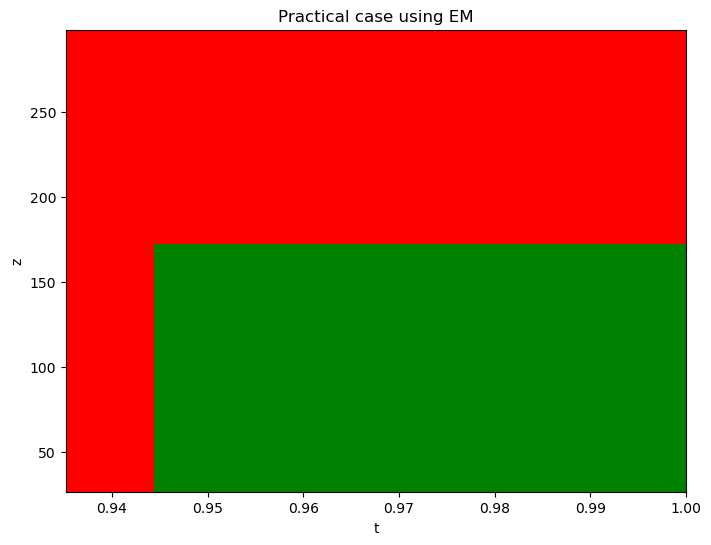

In [54]:
# Plotting
OSB_visualisation_practical_case(N = mesh, value_function = value_function_EM, X_vals = X_vals_EM, volatility = volatility_EM, Z_0 = Z_0, t_0 = t_testing[0], title = "Practical case using EM", name = "Practical_case_EM.png")

## KDE

In [55]:
# OSB estimation
# Temporal mesh
mesh = len(t_testing)
t_mesh = np.linspace(t_testing[0], 1, mesh) # Temporal grid

# Spatial grid
L = 12500

# Boundary
np.random.seed(123)
value_function_KDE, X_vals_KDE = optimal_stopping_montecarlo_3(mu = "continuous", weights = weights_KDE, parameters = parameters_KDE, N = mesh, a = min(Z_1_KDE)-1, b = max(Z_1_KDE)+1, L = L, M = 4500, alpha = 1.5)

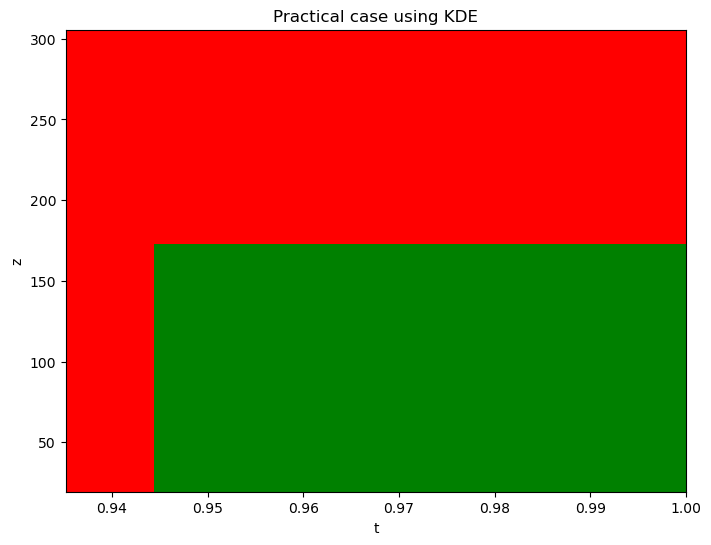

In [56]:
# Plotting
OSB_visualisation_practical_case(N = mesh, value_function = value_function_KDE, X_vals = X_vals_KDE, volatility = volatility_KDE, Z_0 = Z_0, t_0 = t_testing[0], title = "Practical case using KDE", name = "Practical_case_KDE.png")

# First element in stopping region

In [50]:
pair_df_EM = pd.DataFrame({
    'Temporal': t_testing,
    'Spatial': tilde_z_t_testing
})
pair_df_KDE = pair_df_EM.copy()

## EM Algorithm

In [51]:
classificator_EM = process_classificator(N = mesh, value_function = value_function_EM , X_vals = X_vals_EM, volatility = volatility_EM, Z_0 = Z_0, pair_df = pair_df_EM, neighbours = 7)

if np.any(classificator_EM["Prediction"]):
    first_true = np.argmax(classificator_EM["Prediction"])
    first_true_index = tilde_z_t_testing.index[first_true]
    print(f"The first point to enter the stopping region is: \n{df_stocks_result.loc[first_true_index]}")

    subset_df = df_stocks_result.loc[:first_true_index]
    for col in reversed(df_stocks_result.columns):
        na_rows = subset_df[subset_df[col].isna()]
        if not na_rows.empty:
            row_index = na_rows.index[-1]
            print(f"Occured on: {df_stocks_result.loc[row_index]["Time.Interval"][:9]}")
            break

else:
    print("The process remains on the continuation region.")

The process remains on the continue region.


## KDE

In [52]:
classificator_KDE = process_classificator(N = mesh, value_function = value_function_KDE , X_vals = X_vals_KDE, volatility = volatility_KDE, Z_0 = Z_0, pair_df = pair_df_KDE, neighbours = 7)

if np.any(classificator_KDE["Prediction"]):
    first_true = np.argmax(classificator_KDE["Prediction"])
    first_true_index = tilde_z_t_testing.index[first_true]
    print(f"The first point to enter the stopping region is: \n{df_stocks_result.loc[first_true_index]}")

    subset_df = df_stocks_result.loc[:first_true_index]
    for col in reversed(df_stocks_result.columns):
        na_rows = subset_df[subset_df[col].isna()]
        if not na_rows.empty:
            row_index = na_rows.index[-1]
            print(f"Occured on: {df_stocks_result.loc[row_index]["Time.Interval"][:9]}")
            break
else:
    print("The process remains on the continuation region.")

The process remains on the continue region.
